# <center> Data Analysis for OOCS-CNN Results </center>

## Meta
Date: April 23, 2022.  
Author: Parmandeep Chaddha.  
Course: SYDE 552 / BIOL 487.  
Instructor: Dr. Terry Stewart, Dr. Michael Furlong.  

In [147]:
import pandas as pd
import numpy as np
import json
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from math import log

sns.set_style('darkgrid')

In [7]:
## Validation data.
df = pd.DataFrame(
    columns=['test_number', 'inv_accuracy', 'accuracy'],
    data = [
        [1, 82.2, 96.1],
        [2, 91.4, 97.6],
        [3, 92.4, 95.0]
    ]
)
df.describe()

,test_number,inv_accuracy,accuracy
count,3.0,3.000000,3.000000
mean,2.0,88.666667,96.233333
std,1.0,5.622574,1.305118
min,1.0,82.200000,95.000000
25%,1.5,86.800000,95.550000
50%,2.0,91.400000,96.100000
75%,2.5,91.900000,96.850000
max,3.0,92.400000,97.600000


In [241]:
def extract_parameter(stemname, parameter_name='_n', default_value=None):
    this_neuron = [i for i in stemname if parameter_name in i]
    if this_neuron and this_neuron != ' ':
        return int(this_neuron[-1][1:])
    else:
        return default_value
    

def get_file_data(filename, sub='test'):
    df1 = pd.read_json(filename)

    if sub == 'test':
        df1 = df1[
            ['test_acc_original', 'test_loss_original', 'test_acc_inverted', 'test_loss_inverted']
        ]
    elif sub == 'epoch':
        df1 = df1[['val_accs', 'accs', 'losses', 'val_losses']]


    df1['filename'] = filename
    df1 = df1.reset_index().rename(columns={'index': 'epoch_number'})
    
    return df1

def parse_results(filename="neurons", sub='test'):
    all_files = glob.glob(f"./results/{filename}*")
    
    stems = [Path(i).stem.split("_")[1:] for i in all_files]
    
    parsed_data= []
    for file_i, this_file_name in enumerate(all_files):
        this_dict = {}
        this_dict['filename'] = this_file_name
        this_dict['neuron'] = extract_parameter(stems[file_i], 'n', None)
        this_dict['trial_number'] = extract_parameter(stems[file_i], 't', 1)
        this_dict['layer'] = extract_parameter(stems[file_i], 'l', None)
        this_dict['kernel_size'] =\
            extract_parameter(stems[file_i], 'k', 1)        
        if sub == 'test':
            this_data = dict(get_file_data(this_file_name, sub=sub).iloc[-1])
            this_dict = {**this_dict, **this_data}
            parsed_data.append(this_dict)

        if sub == 'epoch':
            this_data = get_file_data(this_file_name, sub=sub).to_dict(orient="records")
            this_data = [{**i, **this_dict} for i in this_data]
            parsed_data = parsed_data + this_data
        
    df = pd.DataFrame(parsed_data)
    return df

In [242]:
def melt_accuracy(df):
    value_vars = ['test_acc_original', 'test_acc_inverted']
    id_vars = [i for i in df.columns if i not in value_vars]
    df = pd.melt(
        df, id_vars=id_vars, value_vars=value_vars,
        var_name='acc_type', value_name='accuracy'
    )
    return df

## Number of Neurons Results

In [243]:
neuron_data = parse_results()
neuron_data_epoch = parse_results(filename='neuron', sub='epoch')

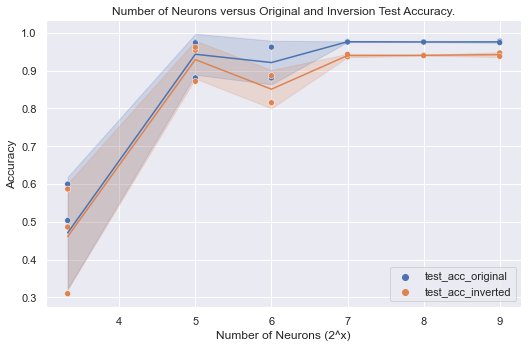

In [207]:
neurons_melt = melt_accuracy(neuron_data)
neurons_melt['neuron'] = neurons_melt['neuron'].apply(lambda x: log(x,2))

sns.set(rc={'figure.figsize':(12,8)})
fig1 = sns.relplot(
    data=neurons_melt,
    x='neuron',
    y='accuracy',
    hue='acc_type',
    kind='line',
    ci="sd",
    aspect=1.5,
    legend=False,
).set(
    xlabel='Number of Neurons (2^x)',
    ylabel='Accuracy',
    title="Number of Neurons versus Original and Inversion Test Accuracy."
)
sns.scatterplot(data=neurons_melt, x='neuron', y='accuracy', hue='acc_type')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('analysis/neurons.png', dpi=400)
neuron_data.to_csv('analysis/neuron_data.csv', index=False)
plt.show()

## Number of Layers

In [197]:
# The control data for this experiment is in the `neurons data` dataframe.
layer_data = parse_results(filename='_l')
control_data = neuron_data[neuron_data.neuron == 64].copy()
control_data['layer'] = 1
layer_data = pd.concat([layer_data, control_data], ignore_index=True)
layer_data

,filename,neuron,trial_number,layer,kernel_size,epoch_number,test_acc_original,test_loss_original,test_acc_inverted,test_loss_inverted
0,./results/_l_l3_n64_t3.json,64,3,3,1,4,0.9784,3.213843,0.9677,3.225535
1,./results/_l_l3_n64_t2.json,64,2,3,1,4,0.8676,3.320639,0.8435,3.349528
2,./results/_l_l2_n64_t1.json,64,1,2,1,4,0.9763,3.215637,0.9585,3.237355
3,./results/_l_l2_n64_t2.json,64,2,2,1,4,0.9781,3.213967,0.9404,3.254774
4,./results/_l_l2_n64_t3.json,64,3,2,1,4,0.9727,3.220904,0.9494,3.249990
5,./results/_l_l3_n64_t1.json,64,1,3,1,4,0.9769,3.216650,0.9462,3.250271
6,./results/neurons_n64.json,64,1,1,1,4,0.9620,3.313565,0.8865,3.339543
7,./results/neurons_n64_t2.json,64,2,1,1,4,0.8804,3.311816,0.8149,3.386085


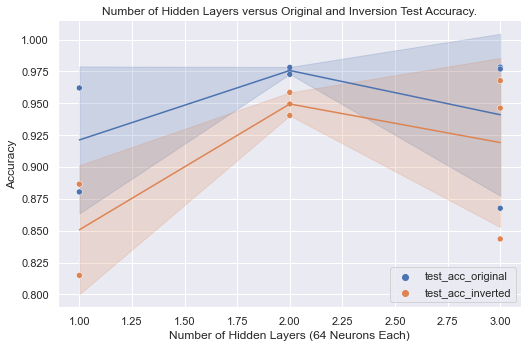

In [208]:
layers_melt = melt_accuracy(layer_data)

sns.set(rc={'figure.figsize':(12,8)})
x_val = 'layer'
fig1 = sns.relplot(
    data=layers_melt,
    x=x_val,
    y='accuracy',
    hue='acc_type',
    kind='line',
    ci="sd",
    aspect=1.5,
    legend=False,
).set(
    xlabel='Number of Hidden Layers (64 Neurons Each)',
    ylabel='Accuracy',
    title="Number of Hidden Layers versus Original and Inversion Test Accuracy."
)
sns.scatterplot(data=layers_melt, x=x_val, y='accuracy', hue='acc_type')
plt.legend(loc='lower right')

plt.tight_layout()
plt.savefig('analysis/layers.png', dpi=400)
layer_data.to_csv('analysis/layer_data.csv', index=False)
plt.show()

## Kernel Size

In [203]:
kernel_data = parse_results(filename='_kernel_size')
kernel_data.to_csv('analysis/kernel_data.csv', index=False)
kernel_data.head()

,filename,neuron,trial_number,layer,kernel_size,epoch_number,test_acc_original,test_loss_original,test_acc_inverted,test_loss_inverted
0,./results/_kernel_size_k2_l1_n100_t3.json,100,3,1,2,2,0.9783,3.657374,0.8065,3.834151
1,./results/_kernel_size_k5_l1_n100_t2.json,100,2,1,5,2,0.8847,3.750384,0.7141,3.928888
2,./results/_kernel_size_k3_l1_n100_t4.json,100,4,1,3,2,0.9637,3.672904,0.9219,3.717668
3,./results/_kernel_size_k2_l1_n100_t2.json,100,2,1,2,2,0.9702,3.664682,0.8138,3.824101
4,./results/_kernel_size_k5_l1_n100_t3.json,100,3,1,5,2,0.9721,3.661507,0.8138,3.830383


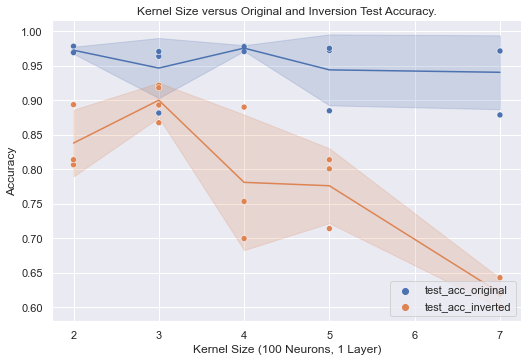

In [205]:
kernel_melt = melt_accuracy(kernel_data)

sns.set(rc={'figure.figsize':(12,8)})
x_val = 'kernel_size'
fig1 = sns.relplot(
    data=kernel_melt,
    x=x_val,
    y='accuracy',
    hue='acc_type',
    kind='line',
    ci="sd",
    aspect=1.5,
    legend=False,
).set(
    xlabel='Kernel Size (100 Neurons, 1 Layer)',
    ylabel='Accuracy',
    title="Kernel Size versus Original and Inversion Test Accuracy."
)
sns.scatterplot(data=kernel_melt, x=x_val, y='accuracy', hue='acc_type')
plt.legend(loc='lower right')
plt.savefig('analysis/kernels.png', dpi=400)
plt.show()

## Hidden Layer - Epochs v. Accuracy

In [268]:
layer_data_epoch = parse_results(filename='_l', sub='epoch')\
    .rename(columns={'layer': 'number_of_hidden_layers'})

control_data = neuron_data_epoch[neuron_data_epoch.neuron == 64].copy()
control_data['number_of_hidden_layers'] = 1
layer_data_epoch = pd.concat([layer_data_epoch, control_data], ignore_index=True)\
    .sort_values(by='number_of_hidden_layers')

layer_data_epoch['epoch_number'] += 1
display(layer_data_epoch)

,epoch_number,val_accs,accs,losses,val_losses,filename,neuron,trial_number,number_of_hidden_layers,kernel_size,layer
39,5,0.882854,0.889021,3.307786,3.311598,./results/neurons_n64_t2.json,64,2,1,1,None
38,4,0.881042,0.886208,3.312582,3.315960,./results/neurons_n64_t2.json,64,2,1,1,None
31,2,0.925729,0.939646,3.327472,3.337505,./results/neurons_n64.json,64,1,1,1,None
32,3,0.939729,0.954646,3.315861,3.323240,./results/neurons_n64.json,64,1,1,1,None
33,4,0.946729,0.962708,3.309348,3.323879,./results/neurons_n64.json,64,1,1,1,None
30,1,0.816146,0.833354,3.441402,3.451674,./results/neurons_n64.json,64,1,1,1,None
35,1,0.667000,0.669458,3.575014,3.576952,./results/neurons_n64_t2.json,64,2,1,1,None
36,2,0.853417,0.859875,3.349969,3.354203,./results/neurons_n64_t2.json,64,2,1,1,None
37,3,0.878771,0.882688,3.319566,3.321270,./results/neurons_n64_t2.json,64,2,1,1,None
34,5,0.955000,0.969792,3.303821,3.314974,./results/neurons_n64.json,64,1,1,1,None


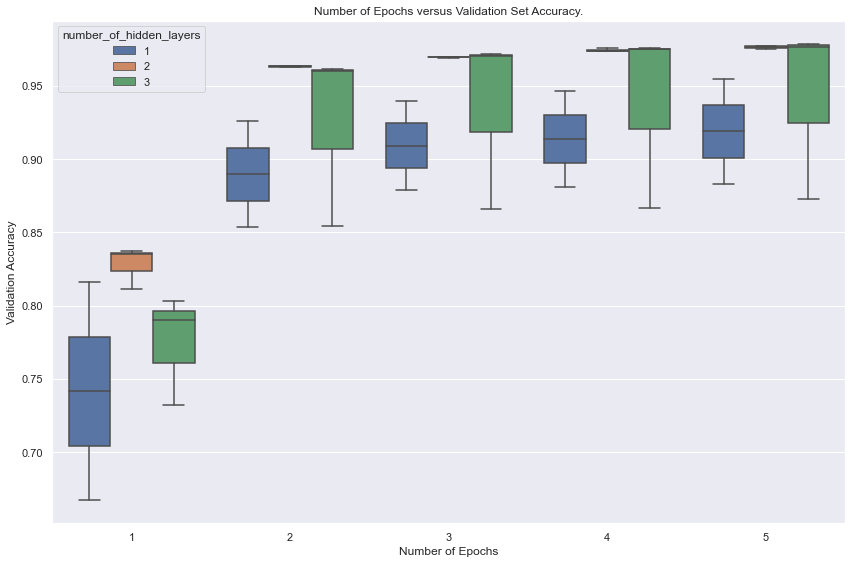

In [287]:
sns.set(rc={'figure.figsize':(12,8)})
x_val = 'epoch_number'
fig1 = sns.boxplot(
    data=layer_data_epoch,
    x=x_val,
    y='val_accs',
    hue='number_of_hidden_layers',
).set(
    xlabel='Number of Epochs',
    ylabel='Validation Accuracy',
    title="Number of Epochs versus Validation Set Accuracy."
)

plt.tight_layout()
plt.savefig('analysis/layers_epoch.png', dpi=400)
layer_data.to_csv('analysis/layer_data_epoch.csv', index=False)
plt.show()

In [275]:
layer_data_epoch[layer_data_epoch.epoch_number == 2]

,epoch_number,val_accs,accs,losses,val_losses,filename,neuron,trial_number,number_of_hidden_layers,kernel_size,layer
31,2,0.925729,0.939646,3.327472,3.337505,./results/neurons_n64.json,64,1,1,1,None
36,2,0.853417,0.859875,3.349969,3.354203,./results/neurons_n64_t2.json,64,2,1,1,None
21,2,0.963354,0.975750,3.234758,3.242798,./results/_l_l2_n64_t3.json,64,3,2,1,NaN
11,2,0.963479,0.976833,3.232562,3.242600,./results/_l_l2_n64_t1.json,64,1,2,1,NaN
16,2,0.962812,0.976917,3.233523,3.242937,./results/_l_l2_n64_t2.json,64,2,2,1,NaN
1,2,0.961792,0.977333,3.233090,3.244187,./results/_l_l3_n64_t3.json,64,3,3,1,NaN
6,2,0.854125,0.865500,3.342434,3.350189,./results/_l_l3_n64_t2.json,64,2,3,1,NaN
26,2,0.960063,0.976313,3.234086,3.245530,./results/_l_l3_n64_t1.json,64,1,3,1,NaN


# Best

In [292]:
best_model = parse_results(filename='_best', sub='test')

best_model.describe()

,neuron,trial_number,layer,kernel_size,epoch_number,test_acc_original,test_loss_original,test_acc_inverted,test_loss_inverted
count,5.0,5.000000,5.0,5.0,5.0,5.000000,5.000000,5.000000,5.000000
mean,128.0,3.000000,2.0,3.0,4.0,0.973580,3.899481,0.931160,3.947528
std,0.0,1.581139,0.0,0.0,0.0,0.002401,0.003840,0.026263,0.028347
min,128.0,1.000000,2.0,3.0,4.0,0.969900,3.894709,0.892400,3.911041
25%,128.0,2.000000,2.0,3.0,4.0,0.973400,3.897896,0.920700,3.935950
50%,128.0,3.000000,2.0,3.0,4.0,0.973900,3.898572,0.938500,3.940840
75%,128.0,4.000000,2.0,3.0,4.0,0.974100,3.901309,0.941700,3.964775
max,128.0,5.000000,2.0,3.0,4.0,0.976600,3.904917,0.962500,3.985032
